In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cs585_common import crop_video, segment_hands, angle_of_wheel_line

In [32]:
# crop video to length. Do not redo this.
input_video_path = 'data/audi_raw_data.mp4'
output_video_path = 'data/audi_gravel_road_footage.mp4'
start_time = (5 * 60)  # seconds
end_time = (8 * 60 + 30)   # seconds

#crop_video(input_video_path, output_video_path, start_time, end_time)

In [33]:
def crop_road_snippet(frame):
    # consts found by trial and error
    return frame[100:200, 500:800]

def crop_steering_wheel(frame):
    return frame[300:850, 300:925]

In [64]:
def segment_gravel_road(frame):
    # convert to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    blurred_frame = cv2.GaussianBlur(hsv_frame, (11, 11), 0)

    lower_gray = np.array([0, 0, 50])
    upper_gray = np.array([179, 50, 220])

    mask = cv2.inRange(blurred_frame, lower_gray, upper_gray)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)

    # Create a mask for the largest contour
    output = np.zeros(mask.shape)
    cv2.drawContours(output, [largest_contour], -1, 1, cv2.FILLED)

    uppermost_point = tuple(hull[hull[:,:,1].argmin()][0])
    
    # Draw the major axis
    ctr = int(mask.shape[1]/2)
    x1, y1 = ctr, mask.shape[0]
    x2, y2 = uppermost_point
    cv2.drawContours(frame, [largest_contour], -1, (0, 255, 0), 5)
    cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

    road_angle = np.rad2deg(np.arctan2((y2 - y1), (x2 - x1)))
    
    return frame, road_angle

def count_l_r_mass(mask):
    # draw centerline
    ctr = int(mask.shape[1]/2)
    
    left_im = mask[0:-1, 0:ctr]
    right_im = mask[0:mask.shape[0], ctr:mask.shape[1]]

    ratio = np.sum(left_im) / np.sum(right_im)

    return ratio

In [68]:
# Open the video file
input_video_path = 'data/audi_gravel_road_footage.mp4'
video_capture = cv2.VideoCapture(input_video_path)

# Loop through frames
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()

    # Check if the frame is successfully read
    if not ret:
        break

    road_frame = crop_road_snippet(frame)
    road_frame, road_angle = segment_gravel_road(road_frame)
    
    wheel_frame = crop_steering_wheel(frame)
    c1, c2 = segment_hands(wheel_frame)
    
    # cv2.line(frame, c1, c2, (0, 255, 0), 2)
    # cv2.circle(frame, c1, 15, (255, 0, 0), -1)
    # cv2.circle(frame, c2, 15, (0, 0, 255), -1)

    angle = angle_of_wheel_line(c1, c2)
    cv2.putText(road_frame, f"Angle: {angle:.4f}", (10, 10), 1, 1, (0, 0, 255))
    cv2.putText(road_frame, f"Angle: {road_angle:.4f}", (10, 30), 1, 1, (255, 0, 0))

    #cv2.putText(frame, f"Ratio: {ratio:.4f}", (10, 100), 1, 2, (0, 255, 0))

    # Display the frame
    cv2.imshow('Frame', road_frame)

    # Wait for key press
    key = cv2.waitKey(0) & 0xFF

    # Quit if 'q' is pressed
    if key == ord('q'):
        break

# Release video capture
video_capture.release()
cv2.destroyAllWindows()

In [74]:
# compute audi wheel/time

wheel_angle_hist = []
road_angle_hist = []

input_video_path = 'data/audi_gravel_road_footage.mp4'
cap = cv2.VideoCapture(input_video_path)
success, frame = cap.read()

fno = 0
failno = 0

while success:

	fno += 1

	try:
		road_frame = crop_road_snippet(frame)
		road_frame, road_angle = segment_gravel_road(road_frame)
		
		wheel_frame = crop_steering_wheel(frame)
		c1, c2 = segment_hands(wheel_frame)
		angle = angle_of_wheel_line(c1, c2)

		wheel_angle_hist.append(angle)
		road_angle_hist.append(road_angle)
	except:
		failno += 1
	
	# read next frame
	success, frame = cap.read()

wheel_angle_arr = np.array(wheel_angle_hist)
np.save('wheel_angle_hist.npy', wheel_angle_arr)

road_angle_arr = np.array(road_angle_hist)

print(f"Failed to analyze {failno} frames out of {fno}")

Failed to analyze 37 frames out of 6091


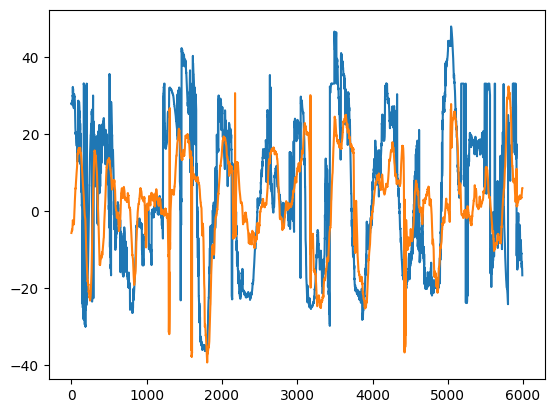

In [77]:
outlier_thresh = 3 * np.std(wheel_angle_hist)
filter_arr = (wheel_angle_arr < outlier_thresh) & (wheel_angle_arr > -outlier_thresh)
wheel_angle_clean = wheel_angle_arr[filter_arr]
road_angle_clean = road_angle_arr[filter_arr]

plt.plot((road_angle_clean + 100)/2)
plt.plot(wheel_angle_clean)

In [28]:
# do world's dumbest regression
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2)